# Notebook 1: Data exploration and pre-processing

This notebook uses data from [Kivisakk et al publication](https://academic.oup.com/braincomms/article/4/4/fcac155/6608340#366642284) as an example/test case to test this proteomics DE analysis workflow using Limma.

This notebook reads in the post-QC'd data from [Table S1 of the associated publication](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/braincomms/4/4/10.1093_braincomms_fcac155/7/fcac155_supplementary_data.zip?Expires=1677768977&Signature=hS7ey1m3UtIF3cV8qEUrfVjgbMTVcf0GPOZpHhVqRh3H44MhG0cFcZz6qwP6GbY2mize0Z1qG87iuYvNQd6-T~KEAPlNR-Ub1YVmenkT~MhkvtURg-MEIns79I9Q49DsKu8LzdbPMWIHvICoiQd~5ET3cUyWRacOkdgfnPsvkN4QTIKWY5uAnHOejaWZHTaf5KgzvqtMcg-dZMx4uuXUyb~3bFLwVCFtU-NwV4J0WdWd0R2QeQuVQMfi5aTdhZWI-QeeAUNvtm1VSQx0NzdQ9TG2Hyfitd8FczWFI32cwWLj~CrtTYbGgtEW3wANXrf89i0fknzRI141ir5XwoHSbQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA) and performs pre-processing and exploratory analysis including:
1. (pre-processing) Filter samples based on metadata
2. (exploration) Examine the distribution of expression per protein and per sample
3. (exploration) PCA visualization of the data to determine if there are any outliers
4. (pre-processing) Normalization

**Note:** Users should determine what additional processing/QC they would need to customize for their own analysis. This notebook is an example.

### As-Is Software Disclaimer

This notebook is delivered "As-Is". Notwithstanding anything to the contrary, DNAnexus will have no warranty, support, liability or other obligations with respect to Materials provided hereunder.

[MIT License](https://github.com/dnanexus/UKB_RAP/blob/main/LICENSE) applies to this notebook.

## JupyterLab app details

<b>Launch spec:</b>
- App name: JupyterLab
- Kernel: ML
- Instance type: mem1_ssd1_v2_x2
- Runtime: =~ 1 min
- Cost ~= £0.0082


<b>Data description:</b> File input for this notebook is
1. csv file containing post-QC'd data from [Table S1 of the associated publication](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/braincomms/4/4/10.1093_braincomms_fcac155/7/fcac155_supplementary_data.zip?Expires=1677768977&Signature=hS7ey1m3UtIF3cV8qEUrfVjgbMTVcf0GPOZpHhVqRh3H44MhG0cFcZz6qwP6GbY2mize0Z1qG87iuYvNQd6-T~KEAPlNR-Ub1YVmenkT~MhkvtURg-MEIns79I9Q49DsKu8LzdbPMWIHvICoiQd~5ET3cUyWRacOkdgfnPsvkN4QTIKWY5uAnHOejaWZHTaf5KgzvqtMcg-dZMx4uuXUyb~3bFLwVCFtU-NwV4J0WdWd0R2QeQuVQMfi5aTdhZWI-QeeAUNvtm1VSQx0NzdQ9TG2Hyfitd8FczWFI32cwWLj~CrtTYbGgtEW3wANXrf89i0fknzRI141ir5XwoHSbQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

### Dependencies

|Library |License|
|:------------- |:-------------|
|[pandas](https://pandas.pydata.org/) |[BSD-3](https://github.com/pandas-dev/pandas/blob/main/LICENSE)|
|[matplotlib](https://matplotlib.org/) |[PSF](https://matplotlib.org/stable/users/project/license.html)|
|[scikit-learn](https://scikit-learn.org/stable/) | [BSD-3](https://github.com/scikit-learn/scikit-learn/blob/main/COPYING)|

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, StandardScaler

In [2]:
# Download supplementary file from publication linked above
# Replace <path on project> with location on your project where you've uploaded the project_DE_analysis to
filename_to_download = (
    "<path on project>/potein_DE_analysis/Supplementary_Table1_Baseline_Olink_Data.csv"
)
filename = "Supplementary_Table1_Baseline_Olink_Data.csv"

# Output directory
output_dir = "/output/"

In [3]:
os.system(" ".join(["dx download", filename]))

768

In [4]:
df = pd.read_csv(filename, index_col=0, header=0)

In [5]:
print(df.shape)
df.head()

(143, 404)


,PIDN,Age_at_Baseline,Sex,Outcome,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,...,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
Plasma_Sample,,,,,,,,,,,,,,,,,,,,,
H0529.3,9677,90+,Male,MCI_Decline_AD,7.62107,6.79971,4.73174,9.33471,3.12445,2.76119,...,2.72481,6.58000,5.53125,3.33948,2.68846,8.83322,6.87415,7.43915,3.41649,6.82437
H0441.1,9974,90+,Female,MCI_Stable_AD,6.96085,6.98459,4.31338,9.06819,3.31576,2.58493,...,3.01428,6.13380,5.56465,3.18228,2.89130,8.98208,6.31876,6.63522,3.62379,6.37066
H0558.3,9681,90+,Female,MCI_Decline_AD,7.16983,7.04907,4.72713,8.92804,3.16308,2.84642,...,2.60958,5.39832,5.02634,2.95021,2.61699,7.80989,5.82366,6.54346,3.91271,5.68429
H0560.2,10195,90+,Female,N,7.45724,6.89523,4.57029,9.27165,3.06199,2.88011,...,2.42160,5.23152,5.35489,2.23073,2.60381,7.92620,5.85513,6.45564,3.17818,5.72402
H0014.1,9513,89,Female,N,7.81354,6.71708,4.93904,9.51350,3.66898,3.15989,...,2.77644,6.62198,5.05462,3.43680,3.10692,9.30726,6.30392,7.22991,3.65764,6.31318


There are 143 individuals and 400 proteins

In [6]:
df["Outcome"].value_counts()

N                 34
Dem_Other         30
MCI_Decline_AD    30
MCI_Stable_AD     29
Dem_AD            20
Name: Outcome, dtype: int64

**Discovery dataset**
* MCI_Stable_AD: Patients with mild cognitive impairements (MIC) that are stable and do not progress to Alzheimer's disease dementia
* MCI_Decline_AD: Patients with mild cognitive impairements (MIC) that progress to Alzheimer's disease dementia

**Dementia & HC**
* N: Healthy control patients that are age and sex matched with no cognitive symptoms
* Dem_AD: Patients with Alzheimer's disease dementia
* Dem_Other: Patients with non-Alzheimer's disease dementia such as frontotemporal dementia, Lewy body disease, or progressive supranuclear palsy

## 2. Filter samples

For this analysis we will be comparing patients with MCI progressive (MCI_Decline_AD) vs MCI stable (MCI_Stable_AD). So we will keep only those patients with Outcome = MCI_Decline_AD and MCI_Stable_AD.

In [7]:
filtered_df = df.query("Outcome=='MCI_Stable_AD' or Outcome=='MCI_Decline_AD'")

In [8]:
print(filtered_df.shape)
filtered_df.head()

(59, 404)


,PIDN,Age_at_Baseline,Sex,Outcome,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,...,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
Plasma_Sample,,,,,,,,,,,,,,,,,,,,,
H0529.3,9677,90+,Male,MCI_Decline_AD,7.62107,6.79971,4.73174,9.33471,3.12445,2.76119,...,2.72481,6.58000,5.53125,3.33948,2.68846,8.83322,6.87415,7.43915,3.41649,6.82437
H0441.1,9974,90+,Female,MCI_Stable_AD,6.96085,6.98459,4.31338,9.06819,3.31576,2.58493,...,3.01428,6.13380,5.56465,3.18228,2.89130,8.98208,6.31876,6.63522,3.62379,6.37066
H0558.3,9681,90+,Female,MCI_Decline_AD,7.16983,7.04907,4.72713,8.92804,3.16308,2.84642,...,2.60958,5.39832,5.02634,2.95021,2.61699,7.80989,5.82366,6.54346,3.91271,5.68429
H0499.2,9502,88,Male,MCI_Stable_AD,7.59577,6.80282,4.51559,9.17979,3.19292,2.71104,...,3.02522,6.03356,5.17391,3.27962,6.21488,8.65480,6.96169,6.80551,3.16607,6.46900
H0468.3,9635,87,Female,MCI_Stable_AD,7.25945,6.91728,4.84307,9.91809,3.47692,3.01978,...,2.26329,5.23342,4.91143,2.10269,2.55051,7.94390,5.32065,6.48469,3.22015,5.99774


## 3. Format data

Split the data into 2 dataframes: NPX data and phenotype data

In [9]:
metadata_colnames = ["PIDN", "Age_at_Baseline", "Sex", "Outcome"]
pheno_df = filtered_df[metadata_colnames]
npx_df = filtered_df.drop(metadata_colnames, axis=1)

In [10]:
print(pheno_df.shape)
pheno_df.head()

(59, 4)


,PIDN,Age_at_Baseline,Sex,Outcome
Plasma_Sample,,,,
H0529.3,9677,90+,Male,MCI_Decline_AD
H0441.1,9974,90+,Female,MCI_Stable_AD
H0558.3,9681,90+,Female,MCI_Decline_AD
H0499.2,9502,88,Male,MCI_Stable_AD
H0468.3,9635,87,Female,MCI_Stable_AD


In [11]:
print(npx_df.shape)
npx_df.head()

(59, 400)


,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,SERPINA7,IGFBP3,CR2,SERPINA5,...,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
Plasma_Sample,,,,,,,,,,,,,,,,,,,,,
H0529.3,7.62107,6.79971,4.73174,9.33471,3.12445,2.76119,5.28013,5.53985,5.83288,7.62461,...,2.72481,6.58000,5.53125,3.33948,2.68846,8.83322,6.87415,7.43915,3.41649,6.82437
H0441.1,6.96085,6.98459,4.31338,9.06819,3.31576,2.58493,5.36719,5.22006,6.54894,7.85164,...,3.01428,6.13380,5.56465,3.18228,2.89130,8.98208,6.31876,6.63522,3.62379,6.37066
H0558.3,7.16983,7.04907,4.72713,8.92804,3.16308,2.84642,5.56897,5.28240,7.06695,7.56996,...,2.60958,5.39832,5.02634,2.95021,2.61699,7.80989,5.82366,6.54346,3.91271,5.68429
H0499.2,7.59577,6.80282,4.51559,9.17979,3.19292,2.71104,5.54439,5.72146,6.77939,8.34760,...,3.02522,6.03356,5.17391,3.27962,6.21488,8.65480,6.96169,6.80551,3.16607,6.46900
H0468.3,7.25945,6.91728,4.84307,9.91809,3.47692,3.01978,5.65406,5.54186,6.06626,8.20922,...,2.26329,5.23342,4.91143,2.10269,2.55051,7.94390,5.32065,6.48469,3.22015,5.99774


## 4. Explore data

In [12]:
# Check if there are there any missing values
npx_df.isna().any().sum()

0

### By protein

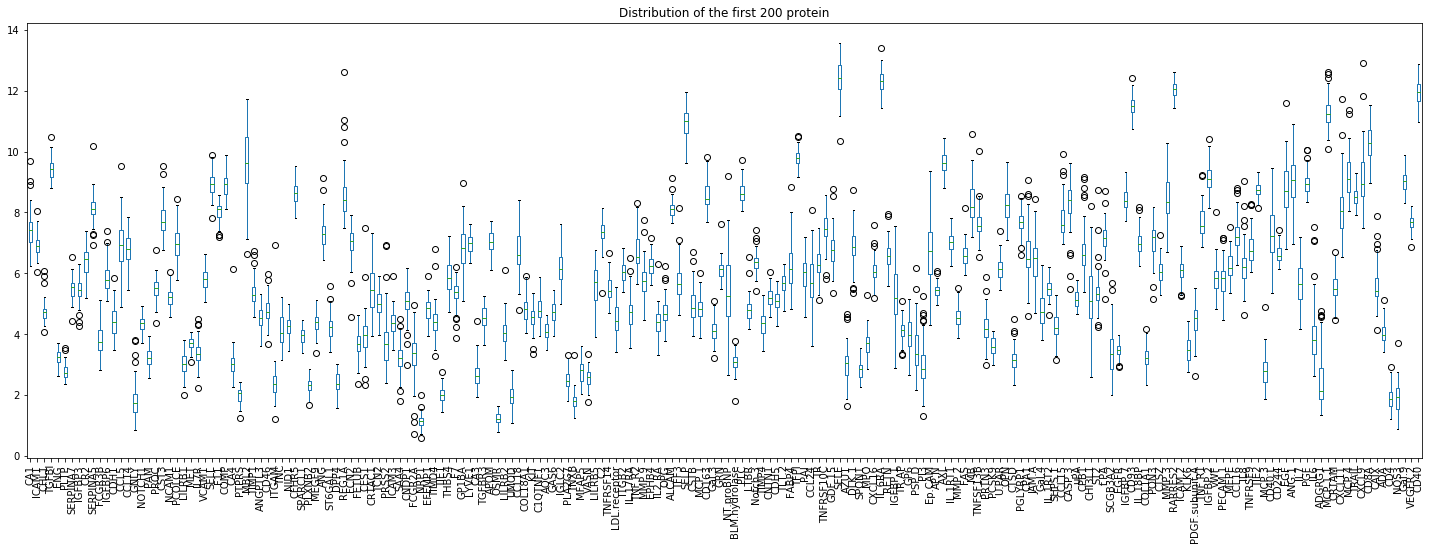

In [13]:
# Let's look at the distribution of expression per protein and per sample
ax = npx_df.iloc[:, 0:200].plot(
    kind="box", title="Distribution of the first 200 protein", figsize=(25, 8)
)
plt.xticks(rotation=90)
plt.show()

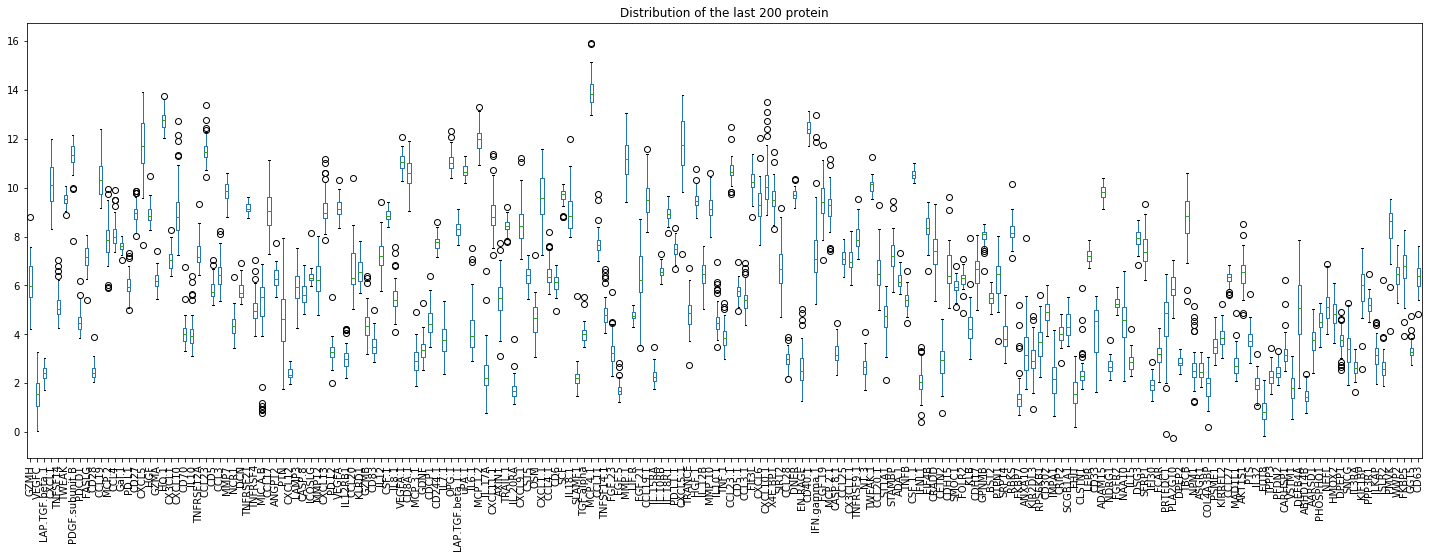

In [14]:
ax = npx_df.iloc[:, 201:400].plot(
    kind="box", title="Distribution of the last 200 protein", figsize=(25, 8)
)
plt.xticks(rotation=90)
plt.show()

### By sample

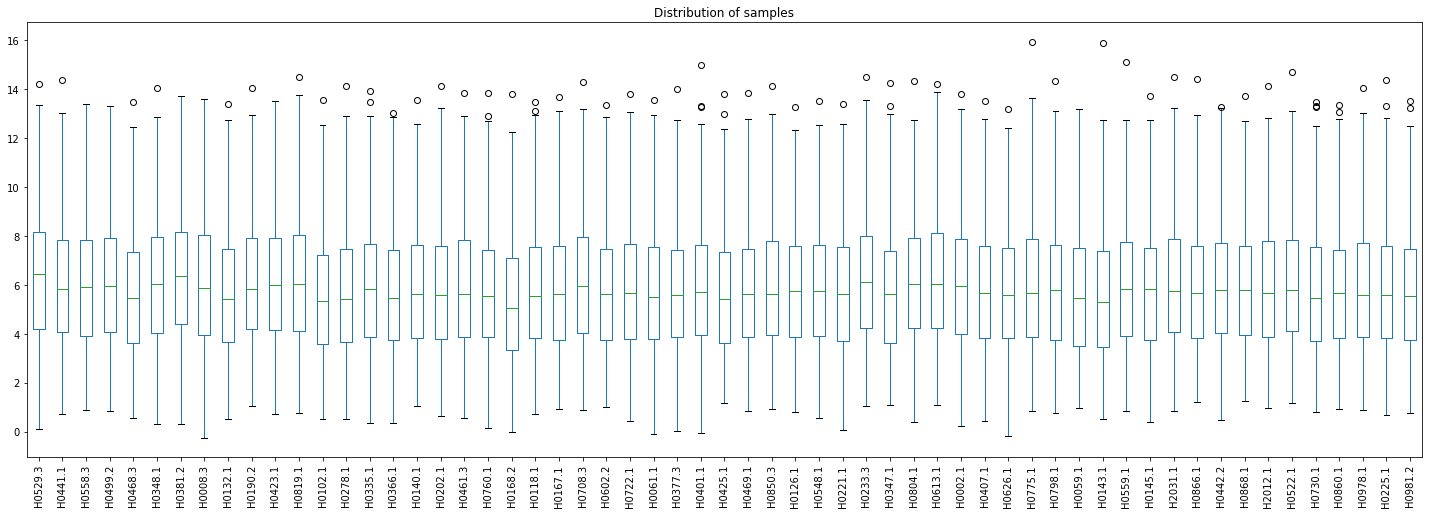

In [15]:
# Let's look at the distribution of expression per protein and per sample
ax = npx_df.T.plot(kind="box", title="Distribution of samples", figsize=(25, 8))
plt.xticks(rotation=90)
plt.show()

* NPX expression per sample is consistent
* NPX expression is very variable across proteins

## 5. Normalize data

First, let's normalize the data so that the protein expression have similar distributions. If there are large differences between the ranges of features, those features with larger ranges will dominate over those will smaller ranges (https://builtin.com/data-science/step-step-explanation-principal-component-analysis).

<!--
Here we perform a [quantile normalization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer), which scales the data to be from the same distribution. The type of normalization used can be switched out with a different method - see possible methods [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
-->

The publication said that `continuous variables were centred and scaled for all analyses`. So we will z-score the data.

**Note:** Users can choose what type of normalization, if any, to perform

In [16]:
# Normalize per protein
# scaler = QuantileTransformer()
scaler = StandardScaler()

npx_normalized = scaler.fit_transform(npx_df)
npx_normalized_df = pd.DataFrame(
    data=npx_normalized,
    columns=npx_df.columns,
    index=npx_df.index,
)

In [17]:
print(npx_normalized_df.shape)
npx_normalized_df.head()

(59, 400)


,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,SERPINA7,IGFBP3,CR2,SERPINA5,...,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
Plasma_Sample,,,,,,,,,,,,,,,,,,,,,
H0529.3,0.302136,-0.342051,-0.027948,-0.277329,-0.476881,-0.010246,-0.620891,0.204681,-1.212845,-1.062602,...,0.199381,0.814834,0.776378,0.393731,0.000065,0.535867,0.907559,0.862357,0.203071,0.926589
H0441.1,-0.721635,0.179791,-1.190228,-0.997705,0.340137,-0.743486,-0.382309,-0.539743,0.343401,-0.573643,...,0.978865,0.288773,0.867820,0.111321,0.327440,0.698649,-0.205136,-0.062495,0.819732,0.098078
H0558.3,-0.397580,0.361792,-0.040755,-1.376516,-0.311906,0.344309,0.170657,-0.394625,1.469217,-1.180303,...,-0.110910,-0.578342,-0.605946,-0.305594,-0.115285,-0.583173,-1.197044,-0.168057,1.679190,-1.155289
H0499.2,0.262905,-0.333273,-0.628452,-0.696062,-0.184469,-0.218870,0.103297,0.627442,0.844249,0.494517,...,1.008324,0.170592,-0.201934,0.286193,5.691554,0.340759,1.082941,0.133409,-0.541859,0.277655
H0468.3,-0.258610,-0.010198,0.281347,1.299488,1.028394,1.065485,0.403841,0.209360,-0.705630,0.196485,...,-1.043399,-0.772756,-0.920542,-1.828169,-0.222580,-0.436630,-2.204798,-0.235667,-0.380986,-0.582904


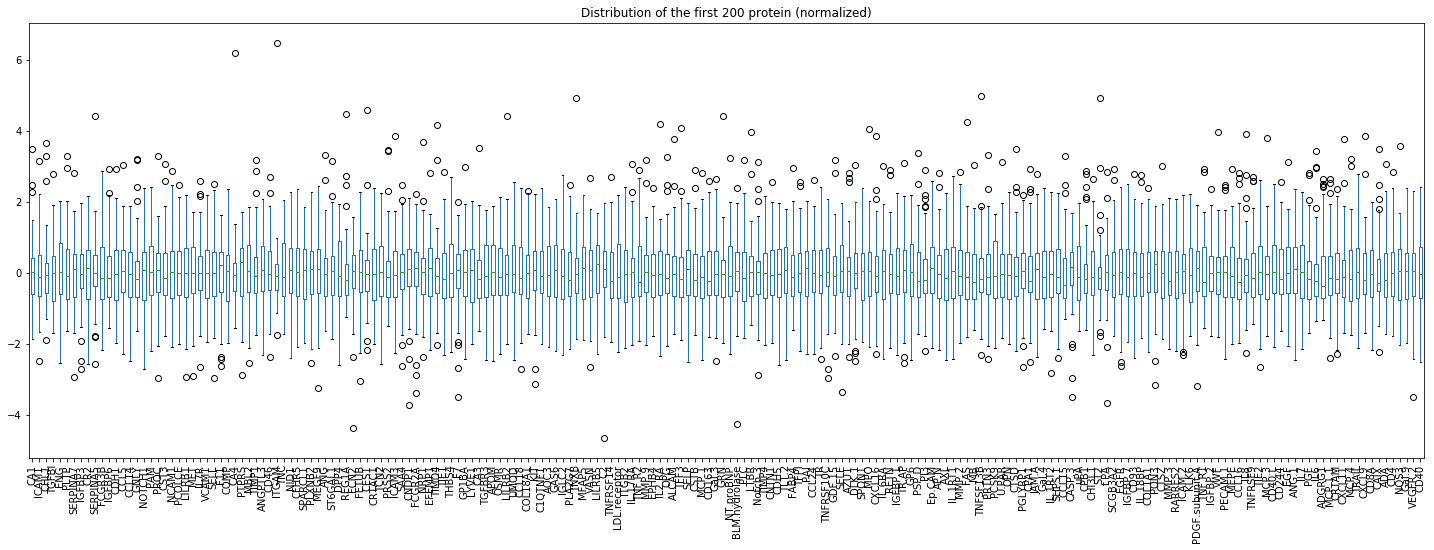

In [18]:
# Let's look at the distribution after we've normalized
ax = npx_normalized_df.iloc[:, 0:200].plot(
    kind="box",
    title="Distribution of the first 200 protein (normalized)",
    figsize=(25, 8),
)
plt.xticks(rotation=90)
plt.show()

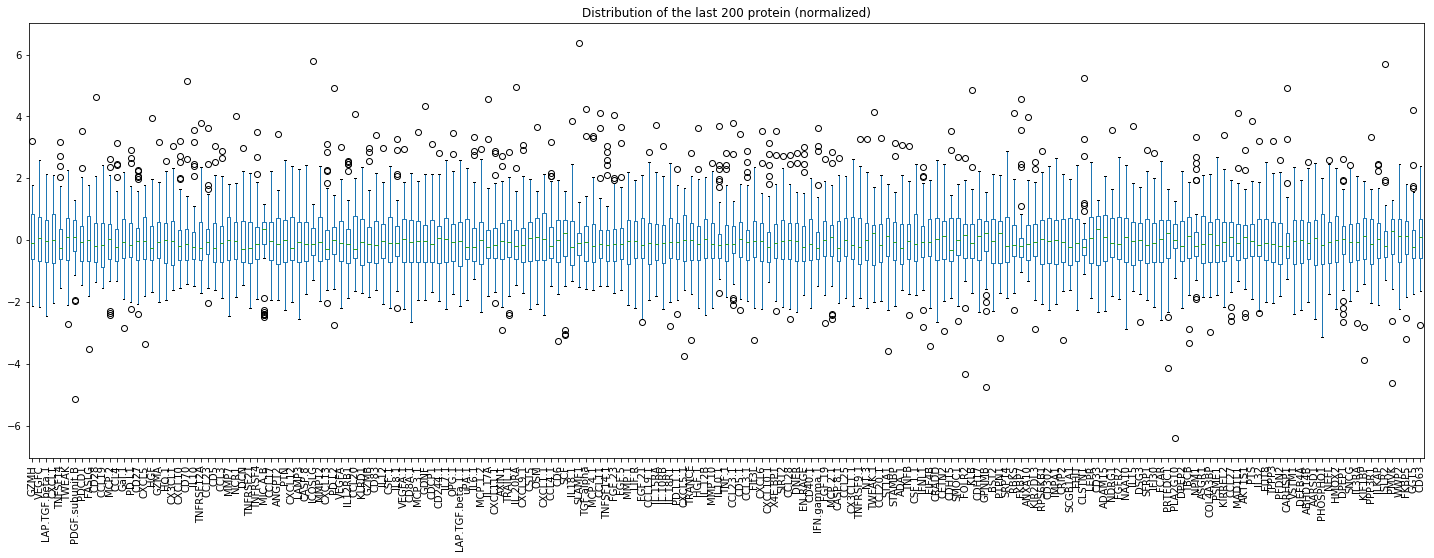

In [19]:
# Let's look at the distribution after we've normalized
ax = npx_normalized_df.iloc[:, 201:400].plot(
    kind="box",
    title="Distribution of the last 200 protein (normalized)",
    figsize=(25, 8),
)
plt.xticks(rotation=90)
plt.show()

## 6. PCA

Let's perform PCA to determine if there are any outlier samples. Since the data is post-QC, we're not expecting to find any.

Since PCA is sensitive to variances in the input variables, we will use the normalized data as input. In other words, if there are large differences in ranges between input variables, those large ranges will dominate the signal detected and lead to biased results.

In [20]:
# Embed expression data into low dimensional space
pca = PCA(n_components=2)
model = pca.fit(npx_normalized_df)
npx_encoded = model.transform(npx_normalized_df)

npx_encoded_df = pd.DataFrame(
    data=npx_encoded, index=npx_normalized_df.index, columns=["PC1", "PC2"]
)

In [21]:
# Add metadata to color samples
npx_encoded_label_df = npx_encoded_df.merge(pheno_df, left_index=True, right_index=True)

In [22]:
print(npx_encoded_label_df.shape)
npx_encoded_label_df.head()

(59, 6)


,1,2,PIDN,Age_at_Baseline,Sex,Outcome
Plasma_Sample,,,,,,
H0529.3,20.697900,7.922383,9677,90+,Male,MCI_Decline_AD
H0441.1,6.464594,3.279352,9974,90+,Female,MCI_Stable_AD
H0558.3,12.626125,-7.003717,9681,90+,Female,MCI_Decline_AD
H0499.2,9.044782,-0.277782,9502,88,Male,MCI_Stable_AD
H0468.3,-10.876616,-9.917587,9635,87,Female,MCI_Stable_AD


In [23]:
# Create dictionary to map string to numbers to color samples in PCA plot
cmap_outcome = {"MCI_Stable_AD": 0, "MCI_Decline_AD": 1}

In [24]:
npx_encoded_label_df["Outcome_map"] = npx_encoded_label_df["Outcome"].map(cmap_outcome)

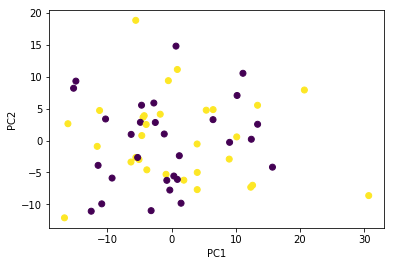

In [25]:
plt.scatter(
    npx_encoded_label_df["PC1"],
    npx_encoded_label_df["PC2"],
    c=npx_encoded_label_df["Outcome_map"],
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Based on the PCA plot, there doesn't look like there are outlier samples. There also isn't a clear linear distinction between MCI Stable and MCI progressive samples.

## 7. Save

Save un-normalized and normalized data to test the affect of normalization on differential expression analysis results.

In [26]:
pheno_df.to_csv("pheno.csv")
npx_df.to_csv("npx.csv")
npx_normalized_df.to_csv("npx_normalized.csv")

In [27]:
# Upload the counts csv to the project
os.system(" ".join(["dx upload", "pheno.csv", "--destination", output_dir]))
os.system(" ".join(["dx upload", "npx.csv", "--destination", output_dir]))
os.system(" ".join(["dx upload", "npx_normalized.csv", "--destination", output_dir]))

0